### Main Project Notebook
In this notebook we will train a UNET CNN model for a simple segmentation task on the Carvana dataset.   

We will go through the following main steps:  
* Data splitting & loading  
* Overfitting a single batch as good practice in order to make sure we have no bugs or logical errors in our code  
* Training our model with the best hyperparameters i found with respect to my computing resources  
* Test our model on the test & sample some random images for visualization  

In [9]:
#basic imports and configurations
import torch
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.tensorboard import SummaryWriter
from math import floor
from model import UNET
from dataset import *

device = "cuda" if torch.cuda.is_available() else "cpu"
imgs_dir = r"C:\Users\matan\Desktop\MLDL_Projects\UNET_Segmentation\Data\images\\"
masks_dir = r"C:\Users\matan\Desktop\MLDL_Projects\UNET_Segmentation\Data\masks\\"

In [2]:
#Hyperparams
lr = 1e-4
batch_size = 16  #Due to memory problem, I believe 32 would be better
num_epochs = 3
img_height = 160
img_width = 160

In [3]:
#Data preprocessing, splitting & loading
transform = A.Compose([
    A.Resize(height=img_height, width=img_width),
    A.Rotate(limit=30, p= 0.1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    ToTensorV2()
])

# Splitting the dataset to train,val,test sets and wrapping each one with a DataLoader
data_dict = TVT_split(imgs_dir, masks_dir, transform=transform, batch_size=batch_size)
train_ds , train_loader = data_dict["train_ds"] , data_dict["train_loader"]
val_ds , val_loader = data_dict["val_ds"] , data_dict["val_loader"]
test_ds , test_loader = data_dict["test_ds"] , data_dict["test_loader"]

#### Overfitting a single batch

In [7]:
overfit_x , overfit_y = next(iter(train_loader))
criterion = nn.CrossEntropyLoss()

def overfit_training_loop(model, optimizer, x, y, epochs):
    for e in range(epochs):
        model.train()
        x = x.float().to(device)
        y = y.long().to(device)

        #forward pass
        scores = model(x)
        loss = criterion(scores, y)  #preforms CEL along the channel dimension

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e%50 == 0:
            print(f"Iteration {e} | loss is : {loss.item():.4f}")

In [6]:
# Training our overfitted model
model_to_overfit = UNET(in_channels=3, out_channels=2).to(device)
optimizer = optim.Adam(model_to_overfit.parameters(), lr=lr)

overfit_training_loop(model_to_overfit, optimizer, overfit_x, overfit_y, epochs=300)

Iteration 0 | loss is : 0.6537
Iteration 50 | loss is : 0.1381
Iteration 100 | loss is : 0.1070
Iteration 150 | loss is : 0.0850
Iteration 200 | loss is : 0.0696
Iteration 250 | loss is : 0.0571


Now that we made sure the model is able to overfit a single batch, we can move on to training the model on the whole dataset.

#### Model Training

In [5]:
#Metrics function for evaluation
def metrics(loader, model):
    num_correct = 0
    num_pixels = 0
    bn_dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.float().to(device)
            y = y.long().to(device)

            scores = model(x)
            pred_mask = torch.argmax(scores, dim=1)
            num_correct += (pred_mask == y).sum()
            num_pixels += torch.numel(pred_mask)
            bn_dice_score += (2*(pred_mask*y).sum()) / ((pred_mask+y).sum() + 1e-8)

        acc = num_correct/num_pixels
        bn_dice_score = bn_dice_score/len(loader)
        return bn_dice_score, acc

In [6]:
criterion = nn.CrossEntropyLoss()

def training_loop(model, optimizer, num_epochs):
    step = 0
    metric_step = 0
    min_loss = float('inf')

    for e in range(num_epochs):
        print()
        print(f"Starting epoch {e + 1}")
        print()

        for idx, (imgs, targets) in enumerate(train_loader):
            model.train()
            imgs = imgs.float().to(device)
            targets = targets.long().to(device)

            #forward pass
            scores = model(imgs)
            loss = criterion(scores, targets)  #preforms CEL along the channel dimension

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            writer.add_scalar('Training loss', loss, global_step= step)
            #maybe add also validation acc here
            step += 1

            if loss.item() < min_loss:
                min_loss = loss.item()
                torch.save(model.state_dict(), "model_ver1.pth")

            if idx%50 == 0:
                bn_dice_score, acc = metrics(val_loader, model)
                writer.add_scalar('Binary Dice Score', bn_dice_score, global_step= metric_step)
                writer.add_scalar('Pixels Accuracy', acc, global_step= metric_step)
                metric_step += 1
                print(f"Batch {idx} | Train_loss: {loss.item():.4f} | Min loss: {min_loss:.4f} | Dice_score: {bn_dice_score:.4f} | Pixel_acc: {acc*100:.2f}%")


In [7]:
model = UNET(in_channels=3, out_channels=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

writer = SummaryWriter(f'TB/model_ver1')
dummy_img = torch.rand(1, 3, img_height, img_width).to(device)
writer.add_graph(model, dummy_img)

training_loop(model, optimizer, num_epochs)
writer.close()

c:\Users\matan\Desktop\MLDL_Projects\UNET_Segmentation\model.py:54: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape != skip_to_cat.shape:                    #Resizing if required before concatenating



Starting epoch 1

Batch 0 | Train_loss: 0.9131 | Min loss: 0.9131 | Dice_score: 0.0304 | Pixel_acc: 78.56%
Batch 50 | Train_loss: 0.1883 | Min loss: 0.1883 | Dice_score: 0.9519 | Pixel_acc: 97.94%
Batch 100 | Train_loss: 0.1544 | Min loss: 0.1516 | Dice_score: 0.9667 | Pixel_acc: 98.59%
Batch 150 | Train_loss: 0.1262 | Min loss: 0.1253 | Dice_score: 0.9729 | Pixel_acc: 98.85%
Batch 200 | Train_loss: 0.1124 | Min loss: 0.1074 | Dice_score: 0.9755 | Pixel_acc: 98.97%
Batch 250 | Train_loss: 0.0972 | Min loss: 0.0972 | Dice_score: 0.9740 | Pixel_acc: 98.89%

Starting epoch 2

Batch 0 | Train_loss: 0.0982 | Min loss: 0.0958 | Dice_score: 0.9762 | Pixel_acc: 98.99%
Batch 50 | Train_loss: 0.0849 | Min loss: 0.0838 | Dice_score: 0.9782 | Pixel_acc: 99.08%
Batch 100 | Train_loss: 0.0774 | Min loss: 0.0737 | Dice_score: 0.9806 | Pixel_acc: 99.18%
Batch 150 | Train_loss: 0.0690 | Min loss: 0.0649 | Dice_score: 0.9789 | Pixel_acc: 99.11%
Batch 200 | Train_loss: 0.0668 | Min loss: 0.0594 | Dice_s

#### Model Testing  
The model achieved pretty good metrics on the validation set, let's see how it performs on the test set.

In [8]:
# Test set metrics
#Loading the final model from the saved model file
final_model = UNET(in_channels=3, out_channels=2).to(device)
final_model.load_state_dict(torch.load("model_ver1.pth"))

fm_dice_score, fm_acc = metrics(test_loader, final_model)
print(f"Model's metrics on the test set | bn_dice_score: {fm_dice_score:.4f} | pixel_acc: {100*fm_acc:.2f}%")

Model's metrics on the test set | bn_dice_score: 0.9805 | pixel_acc: 99.19%


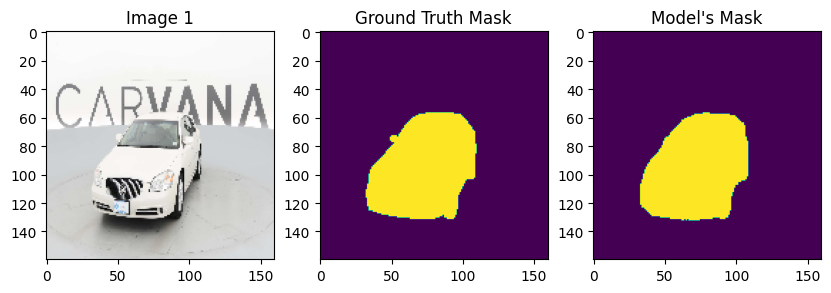

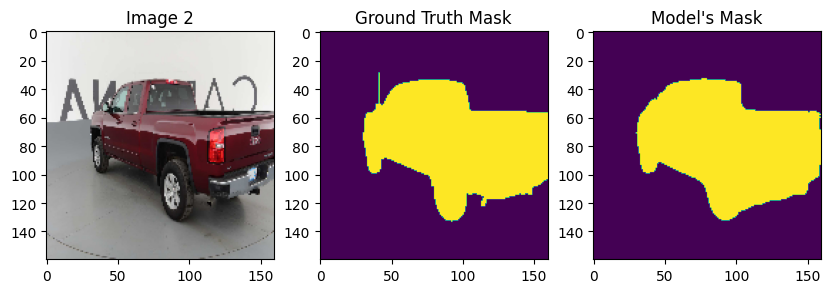

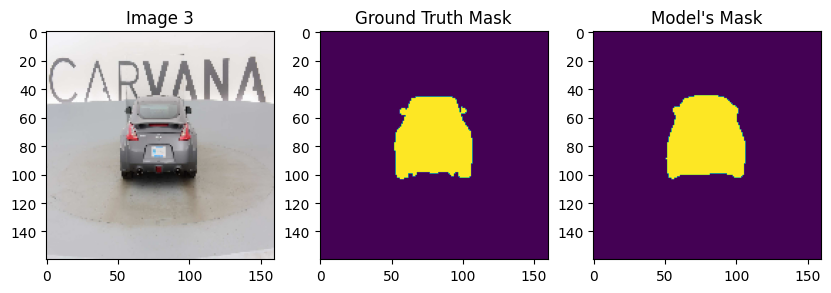

In [73]:
# Sampling and visualizing
def Sample_Segmentation(model, dataset, num_samples= 3):
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            idx = floor(random.random()*len(dataset))
            x , y = dataset[idx]
            x , y = x.float().unsqueeze(0).to(device) , y.long()

            scores = model(x)                           # scores.shape is (1, 2, 160, 160)
            pred_mask = torch.argmax(scores, dim=1)     # pred_mask.shape is (1, 160, 160)

            #squeezing dim 0 for plotting
            pred_mask = pred_mask.squeeze(0).cpu()
            x = x.squeeze(0).long().cpu().permute(1,2,0)

            #plotting everything
            plt.figure(figsize=(10,5))

            plt.subplot(1,3,1)
            plt.imshow(x)
            plt.title(f"Image {i+1}")

            plt.subplot(1,3,2)
            plt.imshow(y)
            plt.title("Ground Truth Mask")

            plt.subplot(1,3,3)
            plt.imshow(pred_mask)
            plt.title("Model's Mask")

            plt.show()

Sample_Segmentation(final_model, test_ds)